### Dataset Comparisons

Using the SSIM metric, this notebook explores whether we can observe a statistically significant difference between the CIFAR 10 and CIFAR 10.1 test datasets.  

To perform this exploration, the team measures the SSIM score between each of the 5k images in each CIFAR10 Training class and the corresponding class images in the two testsets:
  * 1k images in the CIFAR10 Test class (Total scores to compare: 5,000,000)
  * 200 images in the CIFAR 10.1 Test class (Total scores to compare: 1,000,000)

Using the SSIM scores generated from these comparisons, we then test for statistical significance between the two testsets.  

#### Install Libraries and Packages

In [102]:
import numpy as np
import skimage.io as skio
import skimage.filters as skfilt
from skimage import filters
from skimage.measure import compare_ssim as ssim
from scipy import stats
import torchvision
import os
import pandas as pd
from pathlib import Path
import re
from matplotlib import pyplot as plt
%matplotlib inline

#### Load the CIFAR Data

In [51]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
testset = torchvision.datasets.CIFAR10(root='../../data/cifar10/', train=False, download=True)
test_labels_CIFAR10 = testset.targets
test_data_CIFAR10 = testset.data
test_labels_CIFAR101 =np.load('../data/cifar101/cifar10.1_v6_labels.npy')  
test_data_CIFAR101 = np.load('../data/cifar101/cifar10.1_v6_data.npy')

Files already downloaded and verified
Files already downloaded and verified


In [119]:
# Create a dictionary that maps numeric class number to class name
class_dict = {0: "airplane",
              1: "automobile",
              2: "bird",
              3: "cat",
              4: "deer",
              5: "dog",
              6: "frog",
              7: "horse",
              8: "ship",
              9: "truck"
}

#### Load the Predicted Results Data

In [73]:
to_be_101_df = []
to_be_10_df = []

p1 = re.compile("predictions_(.+?)(_cifar101){0,1}.npz")
p2 = re.compile("([\d]+)(_refined)?(\d*)")
p3 = re.compile("ra_(\d+)_(\d+)")

for path in Path('../original_model_results').rglob('*.npz'):
    model = str(path.parent)
    srch1 = p1.search((path.name).lower())
    g1 = srch1.group(1)
    epochs, refined_epochs = 0, 0
    N, M = 0, 0 
    
    if 'refined' in g1:
        epochs = 400
        srch2 = p2.search(g1, re.IGNORECASE)
        if srch2.group(2) != None:
            refined_epochs = srch2.group(3)
        else:
            refined_epochs = srch2.group(1)

    else:
        epochs = g1   
    
    testset = 'cifar101' in (path.name).lower()
    rand_aug = "ra_" in str(path.parent).lower()
    refined = "refined" in (path.name).lower()
    npzf = np.load(path)
    
    if rand_aug:
        srch3 = p3.search(model.lower())
        N = int(srch3.group(1))
        M = int(srch3.group(2))
        
    if testset:
        result_by_img = test_labels_CIFAR101 == npzf['labels']
        to_be_101_df.append([model,testset,rand_aug,int(epochs),int(refined_epochs), N, M] + result_by_img.tolist())
    else:
        result_by_img = test_labels_CIFAR10 == npzf['labels']
        to_be_10_df.append([model,testset,rand_aug,int(epochs),int(refined_epochs), N, M] 
                           + result_by_img.tolist())
        
results_cifar101 = pd.DataFrame(to_be_101_df) 
results_cifar101.rename(columns=lambda x: 'img' + str(x-7), inplace=True)
results_cifar101.rename(columns = {'img-7':"model", 'img-6':"cifar101", 'img-5':"randaug",
                                   'img-4':"epochs", 'img-3':"refined_epochs",
                                   'img-2':"N", 'img-1':"M"
                                  }, inplace=True)

results_cifar10 = pd.DataFrame(to_be_10_df) 
results_cifar10.rename(columns=lambda x: 'img' + str(x-7), inplace=True)
results_cifar10.rename(columns = {'img-7':"model", 'img-6':"cifar101", 'img-5':"randaug",
                                  'img-4':"epochs", 'img-3':"refined_epochs",
                                  'img-2':"N", 'img-1':"M"
                                 }, inplace=True)

results_cifar101 = results_cifar101[results_cifar101.groupby(['model'])['epochs']
                                    .transform(max) == results_cifar101['epochs']]
results_cifar10 = results_cifar10[results_cifar10.groupby(['model'])['epochs']
                                    .transform(max) == results_cifar10['epochs']]

results_cifar10_noaug = results_cifar10[results_cifar10["randaug"]==False]
results_cifar101_noaug = results_cifar101[results_cifar101["randaug"]==False]

imgs = [col for col in results_cifar10_noaug.columns if 'img' in col]
img_preds10 = results_cifar10_noaug[imgs].sum(axis=0)

imgs = [col for col in results_cifar101_noaug.columns if 'img' in col]
img_preds101 = results_cifar101_noaug[imgs].sum(axis=0)

In [74]:
img_preds10.describe()

count    10000.00000
mean         6.61310
std          1.20306
min          0.00000
25%          7.00000
50%          7.00000
75%          7.00000
max          7.00000
dtype: float64

In [75]:
img_preds101.describe()

count    2000.000000
mean        6.113000
std         1.797456
min         0.000000
25%         6.000000
50%         7.000000
75%         7.000000
max         7.000000
dtype: float64

In [76]:
# Retrieve the IDs of all images that all models predicted incorrectly for CIFAR 10.1
zero = img_preds101[img_preds101 == 0]
unaug_cifar101_allwrong = zero.index

# Retrieve the IDs of all images that all models predicted incorrectly for CIFAR 10
zero = img_preds10[img_preds10 == 0]
unaug_cifar10_allwrong = zero.index

# Retrieve the IDs of all images that 7 or more models predicted correctly for CIFAR 10
threshold = 7
zero = img_preds10[img_preds10 >= threshold]
unaug_cifar10_allright = zero.index

# Retireve the IDs of all images that 7 or more models predicted correctly for CIFAR 10.1
threshold = 7
zero = img_preds101[img_preds101 >= threshold]
unaug_cifar101_allright = zero.index

In [78]:
print("Number of unaug_cifar101_allwrong", len(unaug_cifar101_allwrong))
print("Number of unaug_cifar10_allwrong", len(unaug_cifar10_allwrong))
print("Number of unaug_cifar10_allright", len(unaug_cifar10_allright))
print("Number of unaug_cifar101_allright", len(unaug_cifar101_allright))

Number of unaug_cifar101_allwrong 68
Number of unaug_cifar10_allwrong 105
Number of unaug_cifar10_allright 8583
Number of unaug_cifar101_allright 1426


#### Function Definitions

In [96]:
# Given a dataset and its corresponding labels, break the dataset into 
# its respective classes.  Return the result as a dictionary of lists
# where the keys of the dictionary represent the class label.
def dataset_byclass(dataset, labels):
    
    class_lists = {0: [], 1: [], 2: [], 3: [], 4: [],
                   5: [], 6: [], 7: [], 8: [], 9: []
                  }
    
    for l,i in zip(labels, dataset):
        #class_counts[l] += 1
        class_lists[l].append(i)
        
    return class_lists


# Compare quantity 'sample_size' of images from train to each element of 
# the class in c10set and c101set
def ssim_byclass(trainset, c10set, c101set, train_sample_size, c10_sample_size, c101_sample_size):
      
    train_v_c10 = {0: [], 1: [], 2: [], 3: [], 4: [],
                   5: [], 6: [], 7: [], 8: [], 9: []}
    train_v_c101 = {0: [], 1: [], 2: [], 3: [], 4: [],
                   5: [], 6: [], 7: [], 8: [], 9: []}
    
    for tk in sorted(trainset.keys()):
        for ts in random.sample(trainset[tk], k=train_sample_size):
            for i in random.sample(c10set[tk], k=c10_sample_size):
                train_v_c10[tk].append(ssim(ts, i, multichannel=True))
            for i in random.sample(c101set[tk], k=c101_sample_size):
                train_v_c101[tk].append(ssim(ts, i, multichannel=True))
            
    return train_v_c10, train_v_c101

# Compare quantity all images from trainset to each element of the class in 
# c10set and c101set
def ssim_byclass2(trainset, c10set, c101set):

    train_v_c10 = {0: [], 1: [], 2: [], 3: [], 4: [],
                   5: [], 6: [], 7: [], 8: [], 9: []}
    train_v_c101 = {0: [], 1: [], 2: [], 3: [], 4: [],
                   5: [], 6: [], 7: [], 8: [], 9: []}
    
    for tk in sorted(trainset.keys()):
        for ts in trainset[tk]:
            for i in c10set[tk]:
                train_v_c10[tk].append(ssim(ts, i, multichannel=True))
            for i in c101set[tk]:
                train_v_c101[tk].append(ssim(ts, i, multichannel=True))
            
    return train_v_c10, train_v_c101

In [97]:
train = dataset_byclass(trainset.data, trainset.targets)
c10 = dataset_byclass(test_data_CIFAR10, test_labels_CIFAR10)
c101 = dataset_byclass(test_data_CIFAR101, test_labels_CIFAR101)

allright10 = [int(sub[ 3: ]) for sub in list(unaug_cifar10_allright)] 
allright101 = [int(sub[ 3: ]) for sub in list(unaug_cifar101_allright)] 
allwrong10 = [int(sub[ 3: ]) for sub in list(unaug_cifar10_allwrong)] 
allwrong101 = [int(sub[ 3: ]) for sub in list(unaug_cifar101_allwrong)]

allright10_labels = [test_labels_CIFAR10[i] for i in allright10]
allright10_data = [test_data_CIFAR10[i] for i in allright10]

allright101_labels = [test_labels_CIFAR101[i] for i in allright101]
allright101_data = [test_data_CIFAR101[i] for i in allright101]

allwrong10_labels = [test_labels_CIFAR10[i] for i in allwrong10]
allwrong10_data = [test_data_CIFAR10[i] for i in allwrong10] 

allwrong101_labels = [test_labels_CIFAR101[i] for i in allwrong101] 
allwrong101_data = [test_data_CIFAR101[i] for i in allwrong101]  

allright10_dict = dataset_byclass(allright10_data, allright10_labels)
allright101_dict = dataset_byclass(allright101_data, allright101_labels)

allwrong10_dict = dataset_byclass(allwrong10_data, allwrong10_labels)
allwrong101_dict = dataset_byclass(allwrong101_data, allwrong101_labels)

In [82]:
# Take a look at the distribution by class of what we always guess correctly
for d, t in zip([allright10_dict, allright101_dict], ["CIFAR10","CIFAR10.1"]):
    print(t, "Testset: Number of Images by Class Predicted Correctly by Every Model")
    for x in d: 
        if isinstance(d[x], list): 
            print(x, len(d[x])) 
            
# Take a look at the distribution by class of what we always guess incorrectly
for d, t in zip([allwrong10_dict, allwrong101_dict], ["CIFAR10","CIFAR10.1"]):
    print(t, "Testset: Number of Images by Class Predicted Incorrectly by Every Model")
    for x in d: 
        if isinstance(d[x], list): 
            print(x, len(d[x])) 

CIFAR10 Testset: Number of Images by Class Predicted Correctly by Every Model
0 876
1 941
2 813
3 690
4 863
5 785
6 908
7 890
8 919
9 898
CIFAR10.1 Testset: Number of Images by Class Predicted Correctly by Every Model
0 122
1 126
2 140
3 110
4 151
5 133
6 158
7 161
8 158
9 167
CIFAR10 Testset: Number of Images by Class Predicted Incorrectly by Every Model
0 7
1 6
2 15
3 21
4 8
5 18
6 5
7 10
8 7
9 8
CIFAR10.1 Testset: Number of Images by Class Predicted Incorrectly by Every Model
0 10
1 16
2 3
3 14
4 2
5 7
6 2
7 4
8 6
9 4


In [83]:
train_v_c10, train_v_c101 = ssim_byclass(train, c10, c101, 5000, 1000, 200)

In [85]:
train_v_allrightc10, train_v_allrightc101 = ssim_byclass2(train, allright10_dict, allright101_dict)

In [126]:
train_v_allwrongc10, train_v_allwrongc101 = ssim_byclass2(train, allwrong10_dict, allwrong101_dict)

#### Results Analysis

##### SSIM Score Visualization & T-Test for Entire Datasets

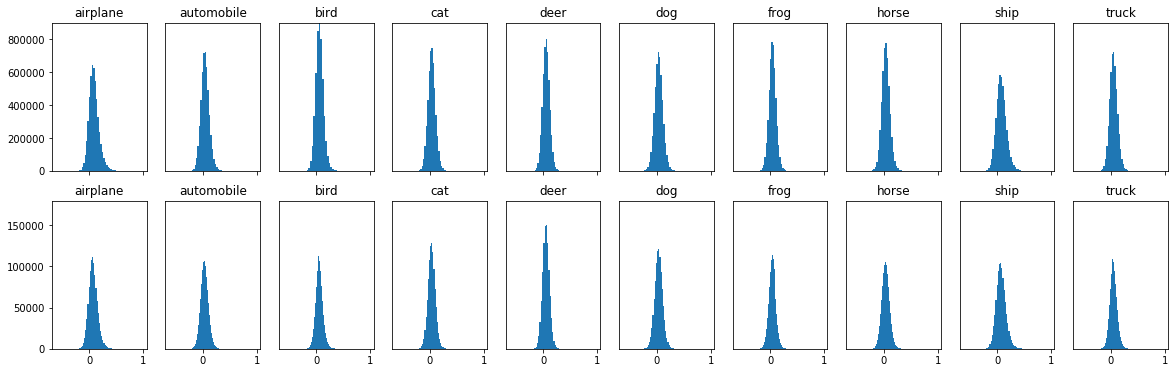

In [125]:
fig, ax = plt.subplots(2,10, figsize=(20, 6), sharex=True)

# Plot information entropy for each dataset, by class
for row, ds, max_y in zip(ax, [train_v_c10, train_v_c101], [900000, 180000]):
    
    # Variable to represent class
    i = 0 
    col = 0
    for c in row:
        if col != 0:
            c.get_yaxis().set_visible(False)
        c.set_title(class_dict[col])
        c.set_ylim(0,max_y)
        c.hist(ds[i], bins=50)
        col += 1
        i += 1

In [116]:
# Calcualte t-scores/p-scores for each class
scores = []
for i in range(len(train_v_c10)):
    scores.append(stats.ttest_ind(train_v_c10[i],train_v_c101[i]))
scores

[Ttest_indResult(statistic=155.98191081137966, pvalue=0.0),
 Ttest_indResult(statistic=78.81138916125342, pvalue=0.0),
 Ttest_indResult(statistic=89.80735325046493, pvalue=0.0),
 Ttest_indResult(statistic=21.04724585353877, pvalue=2.4435875139488683e-98),
 Ttest_indResult(statistic=65.38791278952095, pvalue=0.0),
 Ttest_indResult(statistic=17.72005811003707, pvalue=2.9482525551671783e-70),
 Ttest_indResult(statistic=51.351558568194335, pvalue=0.0),
 Ttest_indResult(statistic=32.63201886361427, pvalue=1.5118074625697855e-233),
 Ttest_indResult(statistic=58.40269746412311, pvalue=0.0),
 Ttest_indResult(statistic=28.97561630755167, pvalue=1.3750520725709206e-184)]

##### SSIM Score Visualization & T-Test for Images that all Models Got Correct

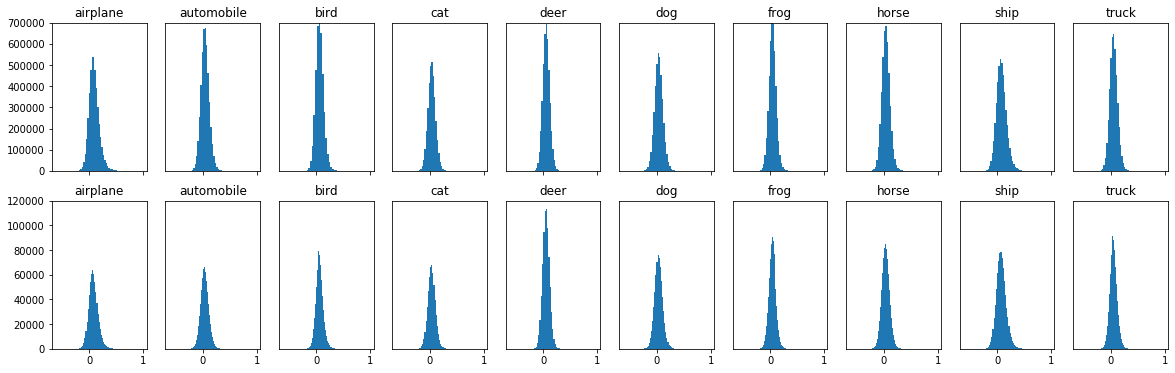

In [124]:
fig, ax = plt.subplots(2,10, figsize=(20, 6), sharex=True)

# Plot information entropy for each dataset, by class
for row, ds, max_y in zip(ax, [train_v_allrightc10, train_v_allrightc101], [700000, 120000]):
    
    # Variable to represent class
    i = 0 
    col = 0
    for c in row:
        if col != 0:
            c.get_yaxis().set_visible(False)
        c.set_title(class_dict[col])
        c.set_ylim(0,max_y)
        c.hist(ds[i], bins=50)
        col += 1
        i += 1
        

In [111]:
# Calcualte t-scores/p-scores for each class
scores_allright = []
for i in range(len(train_v_allrightc10)):
    scores_allright.append(stats.ttest_ind(train_v_allrightc10[i],train_v_allrightc101[i]))
scores_allright

[Ttest_indResult(statistic=98.86278629958674, pvalue=0.0),
 Ttest_indResult(statistic=57.42415956833981, pvalue=0.0),
 Ttest_indResult(statistic=50.63675482190924, pvalue=0.0),
 Ttest_indResult(statistic=23.3433231536695, pvalue=1.6413817479088793e-120),
 Ttest_indResult(statistic=44.47183670587719, pvalue=0.0),
 Ttest_indResult(statistic=22.98941541173574, pvalue=6.040018644163526e-117),
 Ttest_indResult(statistic=34.82605346570019, pvalue=1.051449759210567e-265),
 Ttest_indResult(statistic=30.93234428061471, pvalue=4.585553407252123e-210),
 Ttest_indResult(statistic=26.49222085703321, pvalue=1.2190723337020505e-154),
 Ttest_indResult(statistic=36.63858356069604, pvalue=7.569981334570042e-294)]

##### SSIM Score Visualization & T-Test for Images that all Models Got Wrong

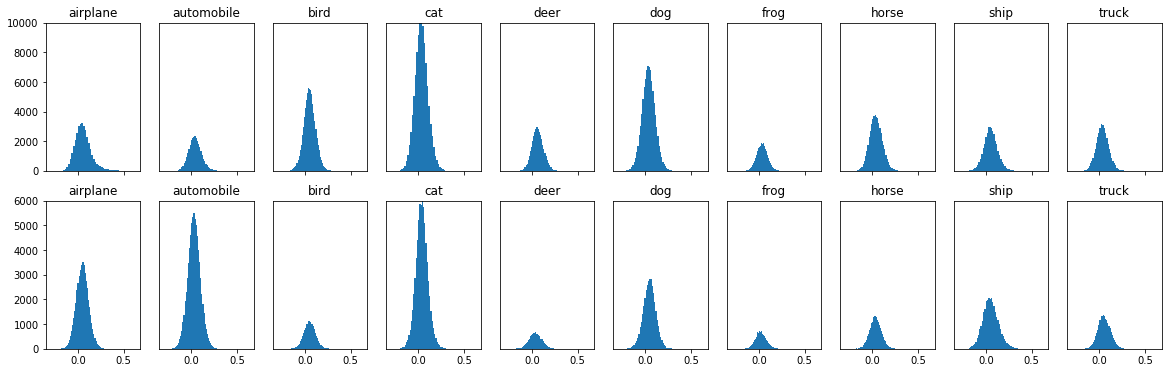

In [123]:
fig, ax = plt.subplots(2,10, figsize=(20, 6), sharex=True)

# Plot information entropy for each dataset, by class
for row, ds, max_y in zip(ax, [train_v_allwrongc10, train_v_allwrongc101], [10000, 6000]):
    
    # Variable to represent class
    i = 0 
    col = 0
    for c in row:
        if col != 0:
            c.get_yaxis().set_visible(False)
        c.set_title(class_dict[col])
        c.set_ylim(0,max_y)
        c.hist(ds[i], bins=50)
        col += 1
        i += 1    

In [117]:
# Calcualte t-scores/p-scores for each class
scores_allwrong = []
for i in range(len(train_v_allrightc10)):
    scores_allwrong.append(stats.ttest_ind(train_v_allwrongc10[i],train_v_allwrongc101[i]))
scores_allwrong

[Ttest_indResult(statistic=12.316326146577303, pvalue=7.923372409325739e-35),
 Ttest_indResult(statistic=24.566544822726616, pvalue=6.586076204220349e-133),
 Ttest_indResult(statistic=-0.8627609520187562, pvalue=0.38827121134026654),
 Ttest_indResult(statistic=-11.136175627672582, pvalue=8.55212746765639e-29),
 Ttest_indResult(statistic=34.17359308870803, pvalue=4.979509889876785e-253),
 Ttest_indResult(statistic=-21.878225960286716, pvalue=6.627629255598769e-106),
 Ttest_indResult(statistic=19.728959521071, pvalue=3.581367409531655e-86),
 Ttest_indResult(statistic=10.402218909057797, pvalue=2.5275335780759475e-25),
 Ttest_indResult(statistic=-1.2390079980171738, pvalue=0.2153470102201569),
 Ttest_indResult(statistic=-30.649005018769618, pvalue=1.0447442488778005e-204)]

**The p-values, while still statistically significant in this subset (the images all models get wrong), are smaller across all classes when compared to the p-scores observed when testing values between both all images in the datasets and the images that all models get correct.**   